https://deep-learning-study.tistory.com/534

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import time
import copy

In [4]:
path='./data'

if not os.path.exists(path):
    os.mkdir(path)

train_ds=datasets.STL10(path, split='train', download=True, transform=transforms.ToTensor())
test_ds=datasets.STL10(path, split='test', download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [10]:
train_meanRGB=[np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds]
train_stdRGB=[np.std(x.numpy(),axis=(1,2)) for x, _ in train_ds]

train_meanR=np.mean([m[0] for m in train_meanRGB])
train_meanG=np.mean([m[1] for m in train_meanRGB])
train_meanB=np.mean([m[2] for m in train_meanRGB])

train_stdR=np.mean([s[0] for s in train_stdRGB])
train_stdG=np.mean([s[1] for s in train_stdRGB])
train_stdB=np.mean([s[2] for s in train_stdRGB])

val_meanRGB=[np.mean(x.numpy(), axis=(1,2)) for x,_ in test_ds]
val_stdRGB=[np.std(x.numpy(), axis=(1,2)) for x,_ in test_ds]

val_meanR=np.mean([m[0] for m in val_meanRGB])
val_meanG=np.mean([m[1] for m in val_meanRGB])
val_meanB=np.mean([m[2] for m in val_meanRGB])

val_stdR=np.mean([s[0] for s in val_stdRGB])
val_stdG=np.mean([s[1] for s in val_stdRGB])
val_stdB=np.mean([s[2] for s in val_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(val_meanR, val_meanG, val_meanB)

0.4467106 0.43980986 0.40664646
0.44723064 0.4396425 0.40495726


In [11]:
train_transformation=transforms.Compose([transforms.ToTensor(), 
                                         transforms.Resize(224), 
                                         transforms.Normalize([train_meanR, train_meanG,train_meanB],
                                                              [train_stdR,train_stdG,train_stdB]),
                                        transforms.RandomHorizontalFlip()])
val_transformation=transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize(224),
                                      transforms.Normalize([val_meanR, val_meanG, val_meanB],
                                                           [val_stdR, val_stdG, val_stdB])])

In [12]:
train_ds.transform=train_transformation
test_ds.transform=val_transformation

train_dl=DataLoader(train_ds, batch_size=32,shuffle=True)
test_dl=DataLoader(test_ds, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image indices: [ 235 3980  905 2763]
(3, 228, 906)
(228, 906, 3)


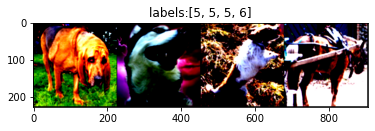

In [26]:
def show(img, y=None, color=True):
    npimg=img.numpy()
    print(npimg.shape)
    npimg_tr=np.transpose(npimg, (1,2,0))
    print(npimg_tr.shape)
    plt.imshow(npimg_tr)
    
    if y is not None:
        plt.title('labels:'+str(y))

np.random.seed(1)
torch.manual_seed(1)

grid_size=4
rnd_inds=np.random.randint(0, len(train_ds),grid_size)
print('image indices:', rnd_inds)

x_grid=[train_ds[i][0] for i in rnd_inds]
y_grid=[train_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)

show(x_grid,y_grid)


In [28]:
class BasicBlock(nn.Module):
    expansion=1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function=nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3,stride=stride,padding=1,bias=False),
                                            nn.BatchNorm2d(out_channels),
                                            nn.ReLU(),
                                            nn.Conv2d(in_channels, out_channels * BasicBlock.expansion,
                                                      kernel_size=3,stride=stride,padding=1,bias=False),
                                            nn.BatchNorm2d(out_channels*BasicBlock.expansion))
        self.shortcut=nn.Sequential()
        self.relu=nn.ReLU()
        
        if stride!=1 or in_channels!=Basicblock.expansions*out_channels:
            self.shortcut=nn.Sequential(nn.Conv2d(in_channels, out_channels,kernel_size=3,stride=stride,padding=1,bias=False),
                                       nn.BatchNorm2d(out_channels*BasicBlock.expansion))
        def forward(self, x):
            x.self=self.residual_function(x)+self.shortcut(x)
            x=self.relu(x)
            return x

In [30]:
class BottleNeck(nn.Module):
    expansion=4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.residual_function=nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride,bias=False),
                                            nn.BatchNorm2d(out_channels),
                                            nn.ReLU(),
                                            nn.Conv2d(in_channels, out_channels,kernel_size=3, strdie=stride, padding=1,bias=False),
                                            nn.BatchNorm2d(out_channels),
                                            nn.ReLU(),
                                            nn.Conv2d(in_channels, out_channels*BottleNeck.expansion,kernel_size=1,stride=stride,bias=False),
                                            nn.BatchNorm2d(out_channels*BottleNeck.expansion))
        self.shortcut=nn.Sequential()
        self.relu=nn.ReLU()
        
        if stride!=1 or in_channels !=in_channels*BottleNeck.expasion:
            self.shorcut=nn.Sequential(nn.Conv2d(in_channels, out_channels*BottleNeck.expansion,kernel_size=1,stride=stride,bias=False),
                                      nn.BatchNorm2d(out_channels*BottleNeck.expansion))
    def forward(self,x):
        x=self.residual_function(x)+self.shortcut(x)
        x=self.relu(x)

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10 init_weights=True):
        super().__init__()
        
        self.in_channels=64
        
        self.conv1=nn.Sequential(nn.Conv2d(3,3,kernel_size=7,stride=2,padding=3,bias=False),
                                nn.BatchNorm2d(64),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=3, stride=2))
        